In [267]:
#first import libraries
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont, ImageEnhance
import os

#tensorflow
import tensorflow as tf
#from tensorflow.python.keras.utils.vis_utils import plot_model

#import time
import time

In [268]:
background_images = 'images/waldo_background.jpg'
waldo = 'images/waldo.png'
wilma = 'images/wilma.png'

In [269]:
import random 

In [270]:
image_waldo = Image.open(waldo) 
image_wilma = Image.open(wilma) 
background = Image.open(background_images)

In [271]:
# store all diff sections in this array 
waldo_sections = [] 

In [272]:
new_size = (101, 200) # Set the new size (width, height) in pixels
image_waldo = image_waldo.resize(new_size)

In [273]:
# Get the dimensions of the image
width, height = image_waldo.size

# need to redefine section height and width randomly every time 
section_width = random.randint(40, 101) 
section_height = random.randint(100, 200) # randomly choosing a section of waldo from 400 (just face) to 1600 (full body)

# Loop through 1000 times
for i in range(1000):
    # Generate random x and y coordinates for the top-left corner of the section
    x = random.randint(0, width - section_width)
    y = 0 # always starting at the top of waldo 

    # need to redefine section height and width randomly every time 
    section_width = random.randint(40, 101) 
    section_height = random.randint(100, 200) # randomly choosing a section of waldo from 400 (just face) to 1600 (full body)

    # Crop the image to the section
    section = image_waldo.crop((x, y, x + section_width, y + section_height))

    # Do something with the section, for example save it to a file
    waldo_sections.append(section) 

In [274]:
# generate sample image using logic from generate_tests 

base_image = background

def generate_sample_image():

    i = random.randint(0, 1000) 

    overlay_image = waldo_sections[i]

    # Get the dimensions of the base image
    base_width, base_height = base_image.size

    # Get the dimensions of the overlay image
    overlay_width, overlay_height = overlay_image.size
    
    # Generate random x and y coordinates for the top-left corner of the overlay image
    x = random.randint(0, base_width - overlay_width)
    y = random.randint(0, base_height - overlay_height)

    # Create a new image with the same dimensions as the base image
    new_image = Image.new("RGB", (base_width, base_height), (0, 0, 0))

    # Paste the base image onto the new image
    new_image.paste(base_image, (0, 0))

    # Paste the overlay image onto the new image at the random coordinates
    new_image.paste(overlay_image, (x, y), overlay_image)

    new_image = new_image.resize((500, 350))

    return new_image, (x,y) 

In [275]:
img, _ = generate_sample_image() 

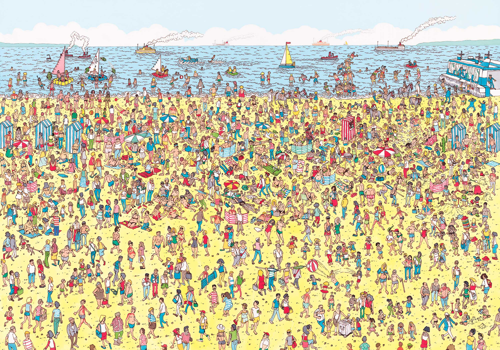

In [276]:
img 

works as expected. able to generate sample images. 

In [277]:
# use this to plot box around waldo once we found dat mf

def plot_bounding_box(image, gt_coords, pred_coords = None):
    
    #convert image to array
    image = Image.fromarray(image)    
    draw = ImageDraw.Draw(image)
    draw.rectangle((gt_coords[0], gt_coords[1], gt_coords[0] + 60, gt_coords[1] + 100), outline = 'green', width = 5)
    
    if pred_coords:
        
        draw.rectangle((pred_coords[0], pred_coords[1], pred_coords[0] + 60, pred_coords[1] + 100), outline = 'red', width = 5)
    
    return image

In [278]:
#create the model
def convolutional_block(inputs):
    
    x = tf.keras.layers.Conv2D(16, 3, padding = 'same', activation = 'relu')(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPool2D(2)(x)
    
    x = tf.keras.layers.Conv2D(32, 3, padding = 'same', activation = 'relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPool2D(2)(x)
    
    x = tf.keras.layers.Conv2D(64, 6, padding = 'valid', activation = 'relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPool2D(2)(x)
        
    x = tf.keras.layers.Conv2D(64, 6, padding = 'valid', activation = 'relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPool2D(2)(x)
    
    return x

def regression_block(x):
    
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(1024, activation = 'relu')(x)
    x = tf.keras.layers.Dense(512, activation = 'relu')(x)
    x = tf.keras.layers.Dense(2, name = 'box')(x)
    
    return x

def classification_block(x):
    
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(1024, activation = 'relu')(x)
    x = tf.keras.layers.Dense(512, activation = 'relu')(x)
    x = tf.keras.layers.Dense(1, activation = 'sigmoid', name = 'class')(x)
    
    return x

In [279]:
from tensorflow.keras.utils import plot_model
#create the model instance
inputs = tf.keras.Input((350, 500, 3),name='image')

#conv block
x = convolutional_block(inputs)

#outputs
box_output = regression_block(x)
class_output = classification_block(x)

#model instance
model = tf.keras.Model(inputs = inputs, outputs = [class_output, box_output])

In [280]:
#custom function to visualize the predictions after epochs
def test_model():
    
    fig, ax = plt.subplots(1, 3, figsize = (15, 5))    
    
    for i in range(3):
        
        #get sample image
        sample_im, pos = generate_sample_image()
        sample_image_normalized = sample_im.resize(350, 500, 3)/255
        predicted_class, predicted_box = model.predict(sample_image_normalized)
        
        #get bounding boxes
        im = plot_bounding_box(sample_im, pos, (predicted_box[0][0], predicted_box[0][1]))
        
        #plot image
        ax[i].imshow(im)
        ax[i].set_xticks([])
        ax[i].set_yticks([])
        ax[i].set_ylabel('True: ' + 'Waldo', color = 'green')
        ax[i].set_xlabel('Predicted: ' + predicted_class, color = 'green') 
        
    plt.show()
        
class VisCallback(tf.keras.callbacks.Callback):
    
    def on_epoch_end(self, epoch, logs = None):
        
        if epoch % 2 == 0:
            
            test_model()
            
#learning rate scheduleer
def lr_schedule(epoch, lr):
    
    if (epoch + 1) % 5 == 0:
        
        lr *= 0.2
    
    return max(lr, 3e-7)

In [281]:
#compile
model.compile(optimizer = tf.keras.optimizers.Adam(), loss = {'class': 'binary_crossentropy', 'box': 'mse'}, \
              metrics = {'class': 'accuracy', 'box': 'mse'})

In [282]:
#data generator function 
def generate_data(batch_size = 16):
    
    while True:
        j = 0
        #create empty arrays for the generated data
        x_batch = np.zeros((batch_size, 350, 500, 3))
        y_batch = np.zeros((batch_size, 1))
        boundary_box = np.zeros((batch_size, 2))
        
        for i in range(batch_size):
            
            #generate an example image
            sample_im, pos = generate_sample_image()
            
            #put the images to the arrays
            x_batch[i] = np.array(sample_im)/255 #normalize
            y_batch[i] = 1
            boundary_box[i, 0] = pos[0]
            boundary_box[i, 1] = pos[1]
            
        yield {'image': x_batch} , {'class': y_batch, 'box': boundary_box}   

In [285]:
#beginning time
tick = time.time()

#fit the model
hist = model.fit(generate_data(), epochs = 10, steps_per_epoch = 100, callbacks = [VisCallback(),tf.keras.callbacks.LearningRateScheduler(lr_schedule)])

#end time
tock = time.time()

Epoch 1/10
 16/100 [===>..........................] - ETA: 2:38 - loss: 555322.2500 - class_loss: 0.0000e+00 - box_loss: 555322.2500 - class_accuracy: 1.0000 - box_mse: 555322.2500

UnknownError: Graph execution error:

IndexError: list index out of range
Traceback (most recent call last):

  File "C:\Users\zayam\AppData\Roaming\Python\Python310\site-packages\tensorflow\python\ops\script_ops.py", line 271, in __call__
    ret = func(*args)

  File "C:\Users\zayam\AppData\Roaming\Python\Python310\site-packages\tensorflow\python\autograph\impl\api.py", line 642, in wrapper
    return func(*args, **kwargs)

  File "C:\Users\zayam\AppData\Roaming\Python\Python310\site-packages\tensorflow\python\data\ops\dataset_ops.py", line 1035, in generator_py_func
    values = next(generator_state.get_iterator(iterator_id))

  File "C:\Users\zayam\AppData\Roaming\Python\Python310\site-packages\keras\engine\data_adapter.py", line 903, in wrapped_generator
    for data in generator_fn():

  File "C:\Users\zayam\AppData\Local\Temp\ipykernel_22192\2172511694.py", line 14, in generate_data
    sample_im, pos = generate_sample_image()

  File "C:\Users\zayam\AppData\Local\Temp\ipykernel_22192\378502662.py", line 9, in generate_sample_image
    overlay_image = waldo_sections[i]

IndexError: list index out of range


	 [[{{node PyFunc}}]]
	 [[IteratorGetNext]] [Op:__inference_train_function_18522]

In [ ]:
#test again in the end a couple of times
for i in range(10):
    test_model()